In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


First You need run:
[2_Conditional DCGAN on MNIST.ipynb](https://colab.research.google.com/drive/1UQ2tcsSx6cYISKLalqZbNu1cP_xT1rng?usp=sharing)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time


In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.project = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * 7 * 7),
            nn.ReLU(True)
        )

        self.net = nn.Sequential(
            nn.Unflatten(1, (128, 7, 7)),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_vec = self.label_emb(labels)
        x = torch.cat((z, label_vec), dim=1)
        x = self.project(x)
        img = self.net(x)
        return img

In [ ]:
latent_dim = 100
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
loaded_G = ConditionalGenerator(latent_dim, num_classes).to(device) # 1) Generator without W
loaded_G.load_state_dict(torch.load("/content/drive/MyDrive/conditional_dcgan_mnist.pth")) #2) upload  W on Generator
loaded_G.eval() # 3)
print("Generator loaded from Drive!")

Generator loaded from Drive!


In [ ]:
z = torch.randn(6, latent_dim, device=device) #latent_dim
labels = torch.tensor([1,1,1,4,5,6], device=device)

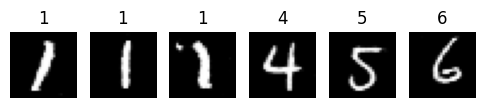

In [ ]:
with torch.no_grad():
    images = loaded_G(z, labels)

imgs = images.squeeze().cpu().numpy()

plt.figure(figsize=(6,2))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(imgs[i], cmap="gray")
    plt.title(str(labels[i].item()))
    plt.axis("off")
plt.show()



In [ ]:
import os
from torchvision.utils import save_image

output_dir = "/content/drive/MyDrive/cario2AliGroup"
os.makedirs(output_dir, exist_ok=True)

z = torch.randn(100, latent_dim, device=device)
labels = torch.randint(0, 10, (100,), device=device)

with torch.no_grad():
    imgs = loaded_G(z, labels)

for i in range(100):
    save_image(imgs[i], f"{output_dir}/img_{i}_label_{labels[i].item()}.png")

print("Images saved to:", output_dir)


Images saved to: /content/drive/MyDrive/cario2AliGroup


In [ ]:
import torch
z = torch.randn(100, 100) # 100 img with dim 100
labels = torch.randint(0, 10, (100,)) # 100 lable image, lable 0 or 1 or 10



In [ ]:
z

tensor([[ 0.2481, -1.8014, -2.4953,  ..., -0.8007,  0.4473, -2.1650],
        [ 0.7582, -1.2364, -0.5617,  ..., -0.2430,  0.3334, -0.1224],
        [ 0.8839,  0.7374,  2.1980,  ..., -0.4293,  0.9750, -0.1996],
        ...,
        [-0.0833,  1.6516,  0.8339,  ...,  0.2169, -0.6196, -0.3775],
        [ 0.1600, -0.3212, -1.1576,  ...,  0.8876, -1.6273, -0.7449],
        [ 0.9200, -0.5879, -0.7742,  ...,  0.0117, -0.0073,  1.3514]])

In [ ]:
labels

tensor([5, 7, 2, 9, 3, 9, 8, 0, 9, 9, 5, 6, 2, 8, 6, 0, 7, 5, 1, 0, 9, 8, 9, 9,
        1, 4, 3, 7, 6, 3, 7, 2, 9, 0, 4, 9, 9, 7, 7, 3, 4, 7, 6, 8, 5, 5, 4, 9,
        3, 6, 2, 7, 8, 1, 4, 7, 7, 2, 3, 6, 0, 7, 2, 5, 8, 2, 1, 5, 3, 5, 3, 9,
        5, 8, 6, 8, 2, 4, 5, 4, 4, 0, 8, 6, 7, 9, 3, 9, 0, 7, 4, 3, 6, 8, 5, 5,
        1, 8, 4, 7])

# How to Evaluate Generated Images (Step-by-Step)


Evaluating generated images should follow a **clear sequence**.
No single metric is enough.

Below is the recommended evaluation pipeline.

---

## Step 1 — Visual Inspection

First, always look at the generated images.

Check for:
- Image clarity
- Noise and artifacts
- Repeated or identical samples
- Obvious failures

> If images look unrealistic, no metric can fix that.

---

## Step 2 — Fréchet Inception Distance (FID)

FID measures how close the generated image distribution is to the real one.

- Lower FID = better realism
- FID compares feature distributions, not pixels
- FID should be computed using the same dataset and setup

> FID gives an overall realism score.

---

## Step 3 — Sample Diversity (Intra-class Diversity)

Check diversity **within each class**.

Questions to ask:
- Do samples from the same class look different?
- Are shapes, styles, or details varied?

Low diversity may indicate **mode collapse**, even if FID is low.

---

## Step 4 — Classifier-based Evaluation

Train a classifier on real data.
Evaluate generated images using this classifier.

Check:
- Classification accuracy
- Prediction confidence

> If the classifier recognizes generated images correctly, they are likely realistic.

---

## Step 5 — Precision vs Recall

Precision measures:
- How realistic the generated samples are

Recall measures:
- How much of the real data distribution is covered

A model may have:
- High precision but low recall (mode collapse)
- High recall but low precision (noisy images)

---

## Final Summary

| Step | Purpose |
|----|--------|
| Visual inspection | Human quality check |
| FID | Overall realism |
| Diversity per class | Detect mode collapse |
| Classifier evaluation | Semantic correctness |
| Precision & Recall | Quality vs coverage |

---

> Generated images should be evaluated using **multiple complementary methods**, not a single score.

1.   Train data real minset >>> classifier >> Trianed model
2.   2000 img real test on Trianed model (acc,Recall,Pr)
2.   2000 img gans test on Trianed model (acc,Recall,Pr)



*   List item



---
---
---

## 1)Fréchet Inception Distance (FID)



### What is FID?

The **Fréchet Inception Distance (FID)** is a metric used to evaluate **generated images**.

It measures **how close the generated images are to real images**.

Instead of comparing pixels directly, FID compares **feature distributions** extracted from a deep neural network (Inception-v3).

---

### How does FID work?

1. Real images are passed through a pretrained **Inception-v3** network.
2. Generated images are passed through the same network.
3. The network extracts **high-level features** from both sets.
4. FID computes the distance between the two feature distributions:
   - Mean
   - Covariance

---

### What does the FID number mean?

- **Lower FID = Better quality**
- **Higher FID = Worse quality**
- **FID = 0** means perfect match (theoretical, almost impossible in practice)

FID does **not** have a fixed range like accuracy.

---

### How do we interpret FID values?

FID values depend on:
- The dataset
- Image complexity
- Preprocessing
- Number of samples

---

### Important notes about FID

- FID values **cannot be compared across different datasets**
- FID is meaningful **only under the same evaluation setup**
- A low FID does **not guarantee high diversity**
- FID should be combined with:
  - Visual inspection
  - Diversity analysis

---

### Summary

- FID measures the **distance between real and generated image distributions**
- Lower values indicate better generation
- FID is a **relative metric**, not an absolute score
- Always interpret FID **within context**

---

> FID helps us understand how realistic generated images are, but it should never be used alone.

In [ ]:
!pip install pytorch-fid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir("/content/drive/MyDrive/DataRealAndFakeOnline")
os.path.exists("/content/drive/MyDrive/DataRealAndFakeOnline/gan") # from GAns


True

In [ ]:
os.path.exists("/content/drive/MyDrive/DataRealAndFakeOnline/real") # from real Dataset /


False

In [ ]:
import os
from torchvision.utils import save_image

output_dir = "/content/drive/MyDrive/DataRealAndFakeOnline/gan"
os.makedirs(output_dir, exist_ok=True)

z = torch.randn(2000, latent_dim, device=device)
labels = torch.randint(0, 10, (2000,), device=device)

with torch.no_grad():
    imgs = loaded_G(z, labels)

for i in range(2000):
    save_image(
        imgs[i],
        f"{output_dir}/img_{i}_label_{labels[i].item()}.png"
    )
print("Images saved to:", output_dir)

Images saved to: /content/drive/MyDrive/DataRealAndFakeOnline/gan


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # نفس GAN
])

dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=1, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.73MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


In [ ]:
real_dir = "/content/drive/MyDrive/DataRealAndFakeOnline/real"
os.makedirs(real_dir, exist_ok=True)

In [ ]:
count = 0

for img, label in loader:
    save_image(
        img,
        f"{real_dir}/real_{count}_label_{label.item()}.png",
        normalize=True
    )
    count += 1
    if count == 1000:
        break

In [ ]:
# 2000  50 = 40

In [ ]:
!python -m pytorch_fid /content/drive/MyDrive/DataRealAndFakeOnline/real /content/drive/MyDrive/DataRealAndFakeOnline/gan --batch-size 50

100% 20/20 [00:07<00:00,  2.67it/s]
100% 40/40 [00:18<00:00,  2.19it/s]
FID:  20.383246144827126


## 2) Sample Diversity (Intra-Class Diversity)


### What is Sample Diversity?

**Sample diversity** measures how **different the generated samples are from each other**.

It answers the question:
> Does the model generate many different samples, or does it repeat the same pattern?

High diversity means the model produces **varied and rich samples**.  
Low diversity often indicates **mode collapse**.

---

### Why is Sample Diversity important?

A model can generate:
- Very realistic images (low FID)
- But only a few repeating patterns

In this case:
- Image quality is high
- Generation health is poor

That is why diversity must be evaluated **together with FID**.

---

### Intra-Class Diversity

In classification datasets (e.g., MNIST), diversity is often measured **per class**.

We ask:
> How diverse are the generated samples within the same class label?

Example:
- Are all generated "7"s similar?
- Or do they show different shapes and styles?

---

### How do we evaluate Sample Diversity?

#### 1. Visual inspection

- Display multiple samples from the same class
- Look for variation in:
  - Shape
  - Thickness
  - Orientation

If many samples look almost identical, diversity is low.

---

#### 2. Distance-based diversity (simple metric)

We compute the **average distance between generated samples** within the same class.

- Larger distance → higher diversity
- Smaller distance → lower diversity

This provides a **numeric estimate** of diversity.

---

#### How do we interpret diversity scores?

- Higher diversity is generally better
- Generated diversity should be **close to real data diversity**
- Slightly lower diversity than real data is normal
- Extremely low diversity indicates **mode collapse**

---

#### Important notes

- Sample diversity does **not measure image quality**
- High diversity alone does not mean good realism
- Diversity must be interpreted **together with FID**

---

## Summary

- Sample diversity measures variation among generated samples
- Intra-class diversity reveals mode collapse
- Diversity complements FID in generative model evaluation

---

## Key takeaway

> A good generative model produces images that are both realistic and diverse.


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def show_class_samples(folder, label, n=10):
    imgs = [f for f in os.listdir(folder) if f"label_{label}" in f][:n]

    plt.figure(figsize=(n, 2))
    for i, img_name in enumerate(imgs):
        img = Image.open(os.path.join(folder, img_name))
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Class {label} diversity")
    plt.show()


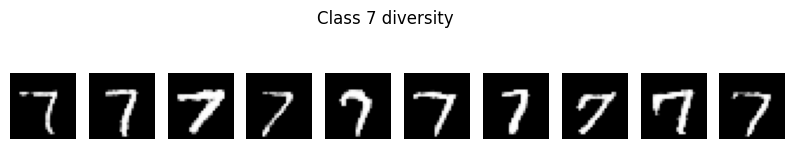

In [ ]:
show_class_samples("/content/drive/MyDrive/DataRealAndFakeOnline/gan", label=7)

In [ ]:
import torch
import numpy as np
from torchvision import transforms

transform = transforms.ToTensor()

def class_diversity(folder, label, max_imgs=50):
    imgs = []
    for f in os.listdir(folder):
        if f"label_{label}" in f:
            img = transform(Image.open(os.path.join(folder, f))) #[C,H, W] >> [C * H * W]
            img = img.view(-1)
            imgs.append(img.view(-1))
            if len(imgs) == max_imgs:
                break

    imgs = torch.stack(imgs) # [N, D] num_img, num_pix
    dists = torch.cdist(imgs, imgs)
    return dists.mean().item()


In [ ]:
for label in range(1,9):
    score = class_diversity("/content/drive/MyDrive/DataRealAndFakeOnline/gan", label)
    print(f"Class {label}: GAN DATA diversity = {score:.4f}")

Class 1: GAN DATA diversity = 11.0041
Class 2: GAN DATA diversity = 16.4285
Class 3: GAN DATA diversity = 14.7371
Class 4: GAN DATA diversity = 15.0260
Class 5: GAN DATA diversity = 15.0882
Class 6: GAN DATA diversity = 15.2827
Class 7: GAN DATA diversity = 13.7670
Class 8: GAN DATA diversity = 16.0674


In [ ]:
for label in range(1,9):
    score = class_diversity("/content/drive/MyDrive/DataRealAndFakeOnline/real", label)
    print(f"Class {label}: Real DATA diversity = {score:.4f}")

Class 1: Real DATA diversity = 10.9928
Class 2: Real DATA diversity = 16.8975
Class 3: Real DATA diversity = 15.9205
Class 4: Real DATA diversity = 15.4797
Class 5: Real DATA diversity = 16.7471
Class 6: Real DATA diversity = 15.8204
Class 7: Real DATA diversity = 14.2265
Class 8: Real DATA diversity = 16.0403
